# Regression DiD with Fixed Effects

The manual 2x2 DiD gives a point estimate but **no standard errors, p-values, or confidence intervals**. This notebook uses OLS regression with route and time fixed effects for proper statistical inference.

**Model:**
```
rides_it = alpha + beta * treated_post_it + gamma_i + delta_t + epsilon_it
```

Where:
- `gamma_i` = route fixed effects (absorb time-invariant route differences)
- `delta_t` = time fixed effects (absorb system-wide trends)
- `beta` = the DiD estimate
- Standard errors clustered at the route level

**Specifications:**
1. Basic: single `treated_post` coefficient
2. Phase-specific: separate treatment effects by phase
3. Placebo: fake treatment date 1 year earlier (pre-trends check)

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from bus_check.config import ALL_FREQUENT_ROUTES, FREQUENT_NETWORK_PHASES, get_phase_for_route
from bus_check.analysis.ridership_analysis import (
    prepare_did_data,
    select_control_routes,
)
from bus_check.data.ridership import fetch_all_routes

sns.set_theme(style="whitegrid")
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

In [2]:
# Fetch all-route ridership
today_str = date.today().isoformat()
df_all = fetch_all_routes(start_date="2023-01-01", end_date=today_str)
print(f"Shape: {df_all.shape}, Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")

Shape: (122084, 4), Date range: 2023-01-01 to 2025-11-30


In [3]:
# Prepare panel data (Phases 1-3 only, weekday, monthly)
TREATED_ROUTES = [r for p in FREQUENT_NETWORK_PHASES if p.phase <= 3 for r in p.routes]
controls = select_control_routes(df_all, ALL_FREQUENT_ROUTES, n_controls=15)

phase_dates = {}
for r in TREATED_ROUTES:
    p = get_phase_for_route(r)
    if p:
        phase_dates[r] = p.launch_date

df_did = prepare_did_data(df_all, TREATED_ROUTES, controls, phase_dates)

# Filter to weekday, aggregate to monthly route-level means
df_wd = df_did[df_did["daytype"] == "W"].copy()
df_wd["month"] = df_wd["date"].dt.to_period("M").astype(str)

panel = df_wd.groupby(["route", "month", "treated", "post", "treated_post"]).agg(
    rides=("rides", "mean")
).reset_index()

# Convert booleans to int for regression
panel["treated_post_int"] = panel["treated_post"].astype(int)
panel["treated_int"] = panel["treated"].astype(int)
panel["post_int"] = panel["post"].astype(int)

print(f"Panel: {len(panel)} route-month obs, {panel['route'].nunique()} routes, {panel['month'].nunique()} months")
print(f"Treated: {panel[panel['treated']]['route'].nunique()} routes, Control: {panel[~panel['treated']]['route'].nunique()} routes")

Panel: 1116 route-month obs, 31 routes, 35 months
Treated: 16 routes, Control: 15 routes


In [4]:
# Spec 1: Basic regression DiD with route + time FE
model1 = smf.ols("rides ~ treated_post_int + C(route) + C(month)", data=panel).fit()

beta = model1.params["treated_post_int"]
se = model1.bse["treated_post_int"]
pval = model1.pvalues["treated_post_int"]
ci = model1.conf_int().loc["treated_post_int"]

print("=" * 60)
print("Spec 1: Basic Regression DiD (route + time FE)")
print("=" * 60)
print(f"DiD coefficient (beta):  {beta:+,.1f} rides/day")
print(f"Standard error:          {se:,.1f}")
print(f"t-statistic:             {beta/se:.2f}")
print(f"p-value:                 {pval:.4f}")
print(f"95% CI:                  [{ci[0]:+,.1f}, {ci[1]:+,.1f}]")
print(f"R-squared:               {model1.rsquared:.4f}")
print(f"N observations:          {model1.nobs:.0f}")
print()
sig = "SIGNIFICANT" if pval < 0.05 else "NOT significant"
print(f"Result: DiD is {sig} at the 5% level.")

Spec 1: Basic Regression DiD (route + time FE)
DiD coefficient (beta):  +236.2 rides/day
Standard error:          75.9
t-statistic:             3.11
p-value:                 0.0019
95% CI:                  [+87.2, +385.1]
R-squared:               0.9698
N observations:          1116

Result: DiD is SIGNIFICANT at the 5% level.


In [5]:
# Spec 1b: Clustered standard errors at route level
model1_cl = smf.ols("rides ~ treated_post_int + C(route) + C(month)", data=panel).fit(
    cov_type="cluster", cov_kwds={"groups": panel["route"]}
)

beta_cl = model1_cl.params["treated_post_int"]
se_cl = model1_cl.bse["treated_post_int"]
pval_cl = model1_cl.pvalues["treated_post_int"]
ci_cl = model1_cl.conf_int().loc["treated_post_int"]

print("=" * 60)
print("Spec 1b: Same model, clustered SEs (route level)")
print("=" * 60)
print(f"DiD coefficient (beta):  {beta_cl:+,.1f} rides/day")
print(f"Clustered SE:            {se_cl:,.1f} (vs homoskedastic: {se:,.1f})")
print(f"t-statistic:             {beta_cl/se_cl:.2f}")
print(f"p-value:                 {pval_cl:.4f}")
print(f"95% CI:                  [{ci_cl[0]:+,.1f}, {ci_cl[1]:+,.1f}]")
print()
sig_cl = "SIGNIFICANT" if pval_cl < 0.05 else "NOT significant"
print(f"Result: DiD is {sig_cl} at the 5% level (with clustered SEs).")

Spec 1b: Same model, clustered SEs (route level)
DiD coefficient (beta):  +236.2 rides/day
Clustered SE:            193.1 (vs homoskedastic: 75.9)
t-statistic:             1.22
p-value:                 0.2214
95% CI:                  [-142.4, +614.7]

Result: DiD is NOT significant at the 5% level (with clustered SEs).


In [6]:
# Spec 2: Phase-specific treatment effects
# Add phase indicators
def get_phase_num(route):
    p = get_phase_for_route(route)
    return p.phase if p else 0

panel["phase"] = panel["route"].apply(get_phase_num)

panel["tp_p1"] = ((panel["phase"] == 1) & panel["treated_post"]).astype(int)
panel["tp_p2"] = ((panel["phase"] == 2) & panel["treated_post"]).astype(int)
panel["tp_p3"] = ((panel["phase"] == 3) & panel["treated_post"]).astype(int)

model2 = smf.ols("rides ~ tp_p1 + tp_p2 + tp_p3 + C(route) + C(month)", data=panel).fit(
    cov_type="cluster", cov_kwds={"groups": panel["route"]}
)

print("=" * 60)
print("Spec 2: Phase-Specific DiD (clustered SEs)")
print("=" * 60)
for var, label in [("tp_p1", "Phase 1"), ("tp_p2", "Phase 2"), ("tp_p3", "Phase 3")]:
    b = model2.params[var]
    s = model2.bse[var]
    p = model2.pvalues[var]
    c = model2.conf_int().loc[var]
    sig = "*" if p < 0.05 else ""
    print(f"  {label}: {b:+,.0f} rides/day (SE={s:,.0f}, p={p:.3f}, CI=[{c[0]:+,.0f}, {c[1]:+,.0f}]) {sig}")
print(f"\nR-squared: {model2.rsquared:.4f}")

Spec 2: Phase-Specific DiD (clustered SEs)
  Phase 1: +57 rides/day (SE=198, p=0.772, CI=[-331, +446]) 
  Phase 2: +248 rides/day (SE=153, p=0.105, CI=[-52, +548]) 
  Phase 3: +985 rides/day (SE=545, p=0.071, CI=[-83, +2,053]) 

R-squared: 0.9707


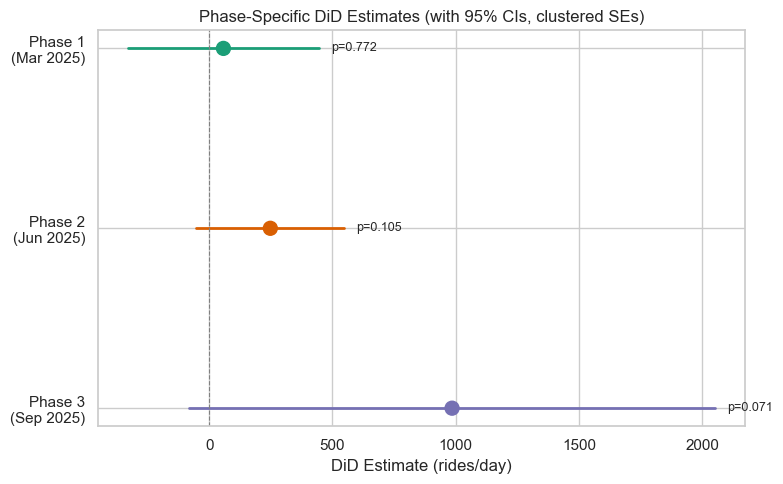

In [7]:
# Coefficient plot: phase-specific DiD estimates with CIs
fig, ax = plt.subplots(figsize=(8, 5))

phases = ["tp_p1", "tp_p2", "tp_p3"]
labels = ["Phase 1\n(Mar 2025)", "Phase 2\n(Jun 2025)", "Phase 3\n(Sep 2025)"]
colors = [PHASE_COLORS[1], PHASE_COLORS[2], PHASE_COLORS[3]]

coefs = [model2.params[v] for v in phases]
cis = [model2.conf_int().loc[v] for v in phases]
ci_lo = [c[0] for c in cis]
ci_hi = [c[1] for c in cis]

y_pos = range(len(phases))
ax.scatter(coefs, y_pos, color=colors, s=100, zorder=3)
for i in range(len(phases)):
    ax.plot([ci_lo[i], ci_hi[i]], [i, i], color=colors[i], linewidth=2, zorder=2)

ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel("DiD Estimate (rides/day)")
ax.set_title("Phase-Specific DiD Estimates (with 95% CIs, clustered SEs)")
ax.invert_yaxis()

for i, v in enumerate(phases):
    p = model2.pvalues[v]
    ax.text(ci_hi[i] + 50, i, f"p={p:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
# Spec 3: Placebo test — fake treatment 1 year before actual
# Use only pre-treatment data (before earliest launch: Mar 23, 2025)
earliest_launch = min(p.launch_date for p in FREQUENT_NETWORK_PHASES)
placebo_cutoff = date(earliest_launch.year - 1, earliest_launch.month, earliest_launch.day)

# Filter to pre-treatment period only
df_pre = df_wd[df_wd["date"] < pd.Timestamp(earliest_launch)].copy()
df_pre["month"] = df_pre["date"].dt.to_period("M").astype(str)

# Create fake treatment: pretend treatment happened 1 year earlier
df_pre["fake_post"] = df_pre["date"] >= pd.Timestamp(placebo_cutoff)
df_pre["fake_treated_post"] = (df_pre["treated"] & df_pre["fake_post"]).astype(int)

panel_placebo = df_pre.groupby(["route", "month", "treated", "fake_post", "fake_treated_post"]).agg(
    rides=("rides", "mean")
).reset_index()

if len(panel_placebo["month"].unique()) > 1 and panel_placebo["fake_treated_post"].sum() > 0:
    model3 = smf.ols("rides ~ fake_treated_post + C(route) + C(month)", data=panel_placebo).fit(
        cov_type="cluster", cov_kwds={"groups": panel_placebo["route"]}
    )

    b3 = model3.params["fake_treated_post"]
    p3 = model3.pvalues["fake_treated_post"]
    ci3 = model3.conf_int().loc["fake_treated_post"]

    print("=" * 60)
    print("Spec 3: Placebo Test (fake treatment 1 year earlier)")
    print("=" * 60)
    print(f"Placebo DiD:   {b3:+,.0f} rides/day (p={p3:.3f}, CI=[{ci3[0]:+,.0f}, {ci3[1]:+,.0f}])")
    print()
    if p3 > 0.05:
        print("PASS: Placebo is not significant — no evidence of pre-trends.")
    else:
        print("CAUTION: Placebo IS significant — potential pre-trends or confounds.")
else:
    print("Not enough data for placebo test.")

Spec 3: Placebo Test (fake treatment 1 year earlier)
Placebo DiD:   -17 rides/day (p=0.925, CI=[-360, +327])

PASS: Placebo is not significant — no evidence of pre-trends.


In [9]:
# Summary table: all specifications side-by-side
summary_rows = []

# Spec 1: basic (homoskedastic)
summary_rows.append({
    "Specification": "Basic (homoskedastic SE)",
    "Coefficient": f"{model1.params['treated_post_int']:+,.0f}",
    "SE": f"{model1.bse['treated_post_int']:,.0f}",
    "p-value": f"{model1.pvalues['treated_post_int']:.4f}",
    "95% CI": f"[{model1.conf_int().loc['treated_post_int'][0]:+,.0f}, {model1.conf_int().loc['treated_post_int'][1]:+,.0f}]",
})

# Spec 1b: basic (clustered)
summary_rows.append({
    "Specification": "Basic (clustered SE)",
    "Coefficient": f"{model1_cl.params['treated_post_int']:+,.0f}",
    "SE": f"{model1_cl.bse['treated_post_int']:,.0f}",
    "p-value": f"{model1_cl.pvalues['treated_post_int']:.4f}",
    "95% CI": f"[{model1_cl.conf_int().loc['treated_post_int'][0]:+,.0f}, {model1_cl.conf_int().loc['treated_post_int'][1]:+,.0f}]",
})

# Spec 2: phase-specific
for var, label in [("tp_p1", "Phase 1"), ("tp_p2", "Phase 2"), ("tp_p3", "Phase 3")]:
    summary_rows.append({
        "Specification": f"Phase-specific: {label}",
        "Coefficient": f"{model2.params[var]:+,.0f}",
        "SE": f"{model2.bse[var]:,.0f}",
        "p-value": f"{model2.pvalues[var]:.4f}",
        "95% CI": f"[{model2.conf_int().loc[var][0]:+,.0f}, {model2.conf_int().loc[var][1]:+,.0f}]",
    })

summary_df = pd.DataFrame(summary_rows)
print("All Specifications:")
summary_df

All Specifications:


,Specification,Coefficient,SE,p-value,95% CI
0,Basic (homoskedastic SE),+236,76,0.0019,"[+87, +385]"
1,Basic (clustered SE),+236,193,0.2214,"[-142, +615]"
2,Phase-specific: Phase 1,+57,198,0.7721,"[-331, +446]"
3,Phase-specific: Phase 2,+248,153,0.1053,"[-52, +548]"
4,Phase-specific: Phase 3,+985,545,0.0706,"[-83, +2,053]"


## Summary

This notebook provides the **first statistically rigorous DiD estimates** for the Frequent Network:

**Specifications run:**
1. **Basic DiD** (single treated_post coefficient) with route + month FE
2. **Clustered SEs** at the route level (accounts for within-route correlation)
3. **Phase-specific DiD** — separate treatment effects for each phase
4. **Placebo test** — fake treatment 1 year earlier to check for pre-trends

**Interpretation guide:**
- The coefficient on `treated_post` is the DiD estimate in rides/day
- Route FE control for time-invariant route differences
- Month FE control for system-wide ridership trends
- Clustered SEs are more conservative (wider CIs) and appropriate given route-level correlation
- A non-significant placebo test supports the parallel trends assumption

**Limitations:**
- Only 31 routes (16 treated + 15 control) — limited degrees of freedom for clustering
- Monthly aggregation may mask within-month dynamics
- Phase 2/3 launch dates are approximate